In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:20.2f}'.format
df=pd.read_excel('C:/Users/mertk/Data Science/Python/Datasets/Excel/online_retail_II.xlsx' , sheet_name= 0 )

In [3]:
df_nona = df.dropna(subset=['Customer ID']).copy()
df_nona[['Invoice','StockCode']] = df_nona[['Invoice','StockCode']].astype('str')
mask1 = (df_nona['Invoice'].str.match(pat='^\\d{6}$') == True)        
df_nona[df_nona['StockCode'].str.match(pat='^\\d{5}[a-zA-Z]*$')==False]['StockCode'].unique()
mask2 = (df_nona['StockCode'].str.match(pat='^\\d{5}[a-zA-Z]*$')==True) | (df_nona['StockCode'].str.match(pat='^SP1002$')==True)
df_nona = df_nona[mask1]
df_stock= df_nona[mask2].copy()

C:\Users\mertk\AppData\Local\Temp\ipykernel_20552\2257939099.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_stock= df_nona[mask2].copy()


In [4]:
df_stock.groupby(by='Country')['Invoice'].nunique().sort_values(ascending=False).head(10)

Country
United Kingdom    17497
Germany             325
EIRE                281
France              222
Netherlands         124
Sweden               64
Spain                58
Belgium              46
Portugal             38
Switzerland          36
Name: Invoice, dtype: int64

In [5]:
df_stock['Amount Spent'] =df_stock['Quantity']*df_stock['Price']
dfstock_feat = df_stock.groupby('Customer ID',as_index=False).agg(
    MonetaryValue = ('Amount Spent','sum'),
    Frequency = ('Invoice','nunique'),
    LastInvo = ('InvoiceDate','max')
)

last_invoice = df_stock['InvoiceDate'].max()
dfstock_feat['Recency'] = (last_invoice -dfstock_feat['LastInvo']).dt.days
dfstock_feat.drop('LastInvo',axis=1,inplace=True)
 

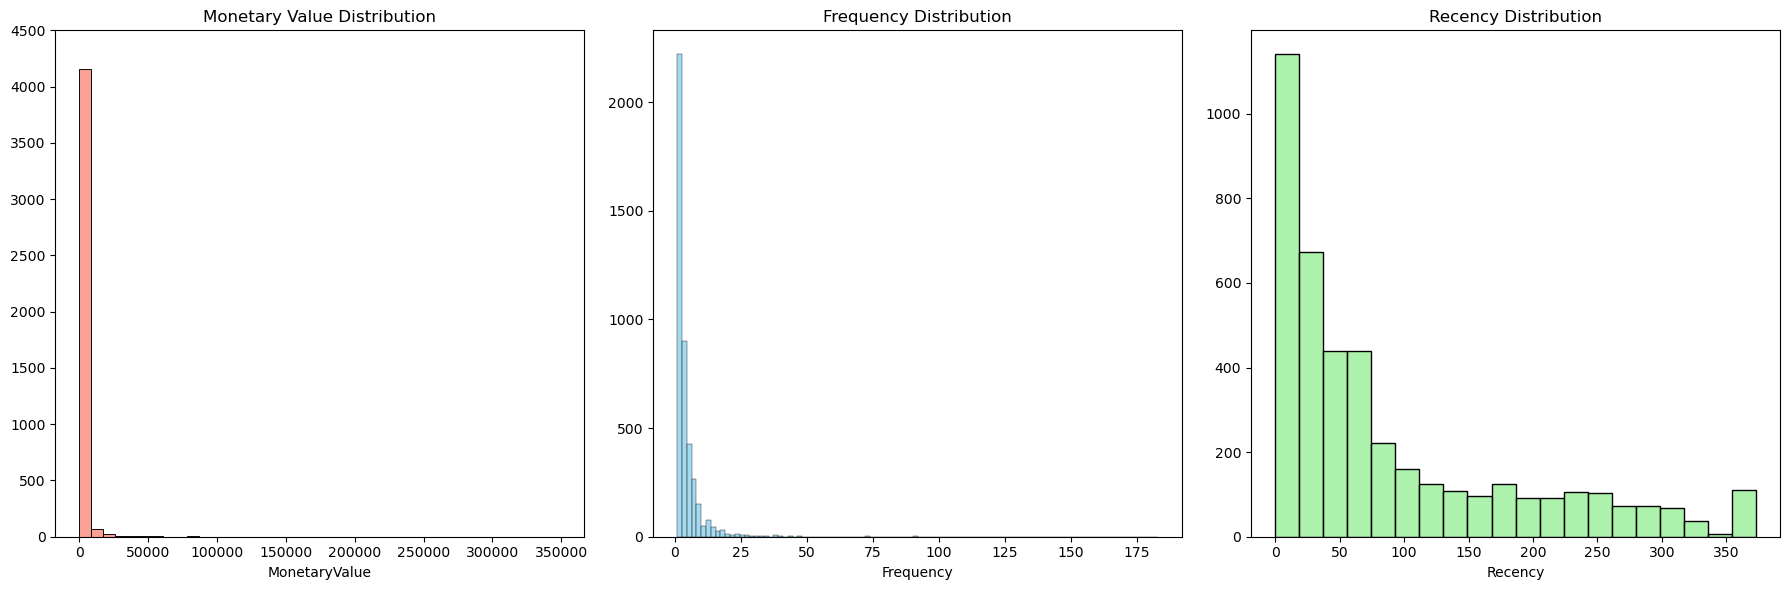

In [6]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
sns.histplot(dfstock_feat['MonetaryValue'] , color='salmon',bins=40)
plt.ylim((0,4500))
plt.title('Monetary Value Distribution')
plt.ylabel('')

plt.subplot(1,3,2)
sns.histplot(dfstock_feat['Frequency'] , color='skyblue',bins=100)
plt.title('Frequency Distribution')
plt.ylabel('')

plt.subplot(1,3,3)
sns.histplot(dfstock_feat['Recency'] , color='lightgreen',bins=20)
plt.title('Recency Distribution')
plt.ylabel('')

plt.tight_layout()
plt.grid(False)
plt.show()

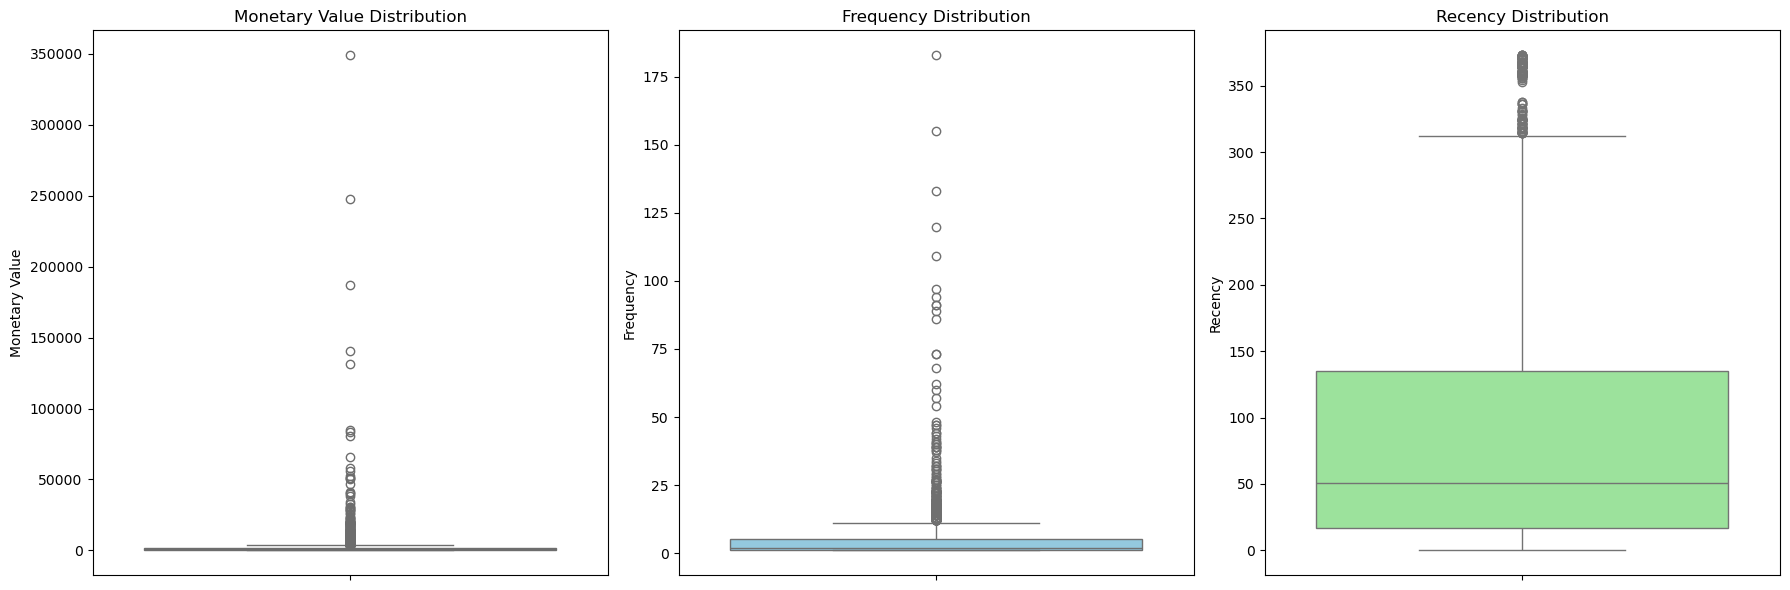

In [7]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
sns.boxplot(y=dfstock_feat['MonetaryValue'] , color='salmon')
plt.title('Monetary Value Distribution')
plt.ylabel('Monetary Value')

plt.subplot(1,3,2)
sns.boxplot(y=dfstock_feat['Frequency'] , color='skyblue')
plt.title('Frequency Distribution')
plt.ylabel('Frequency')

plt.subplot(1,3,3)
sns.boxplot(y=dfstock_feat['Recency'] , color='lightgreen')
plt.title('Recency Distribution')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

In [8]:
mon_Q3 = dfstock_feat['MonetaryValue'].quantile(0.75)
mon_Q1 = dfstock_feat['MonetaryValue'].quantile(0.25)
mon_Q3_Q1 = mon_Q3-mon_Q1 

fre_Q3 = dfstock_feat['Frequency'].quantile(0.75)
fre_Q1 = dfstock_feat['Frequency'].quantile(0.25)
fre_Q3_Q1 = fre_Q3-fre_Q1


In [9]:
mon_upper_bound = mon_Q3 + 1.5 * mon_Q3_Q1
mon_lower_bound = mon_Q1 - 1.5 * mon_Q3_Q1
mon_outliers = dfstock_feat[
    (dfstock_feat['MonetaryValue'] > mon_upper_bound) | 
    (dfstock_feat['MonetaryValue'] < mon_lower_bound)
].copy()

# Detecting Frequency outliers
freq_upper_bound = fre_Q3 + 1.5 * fre_Q3_Q1
freq_lower_bound = fre_Q1 - 1.5 * fre_Q3_Q1
freq_outliers = dfstock_feat[
    (dfstock_feat['Frequency'] > freq_upper_bound) | 
    (dfstock_feat['Frequency'] < freq_lower_bound)
].copy()
non_outlier_df = dfstock_feat[
    ~dfstock_feat.index.isin(mon_outliers.index) & 
    ~dfstock_feat.index.isin(freq_outliers.index)
].copy()

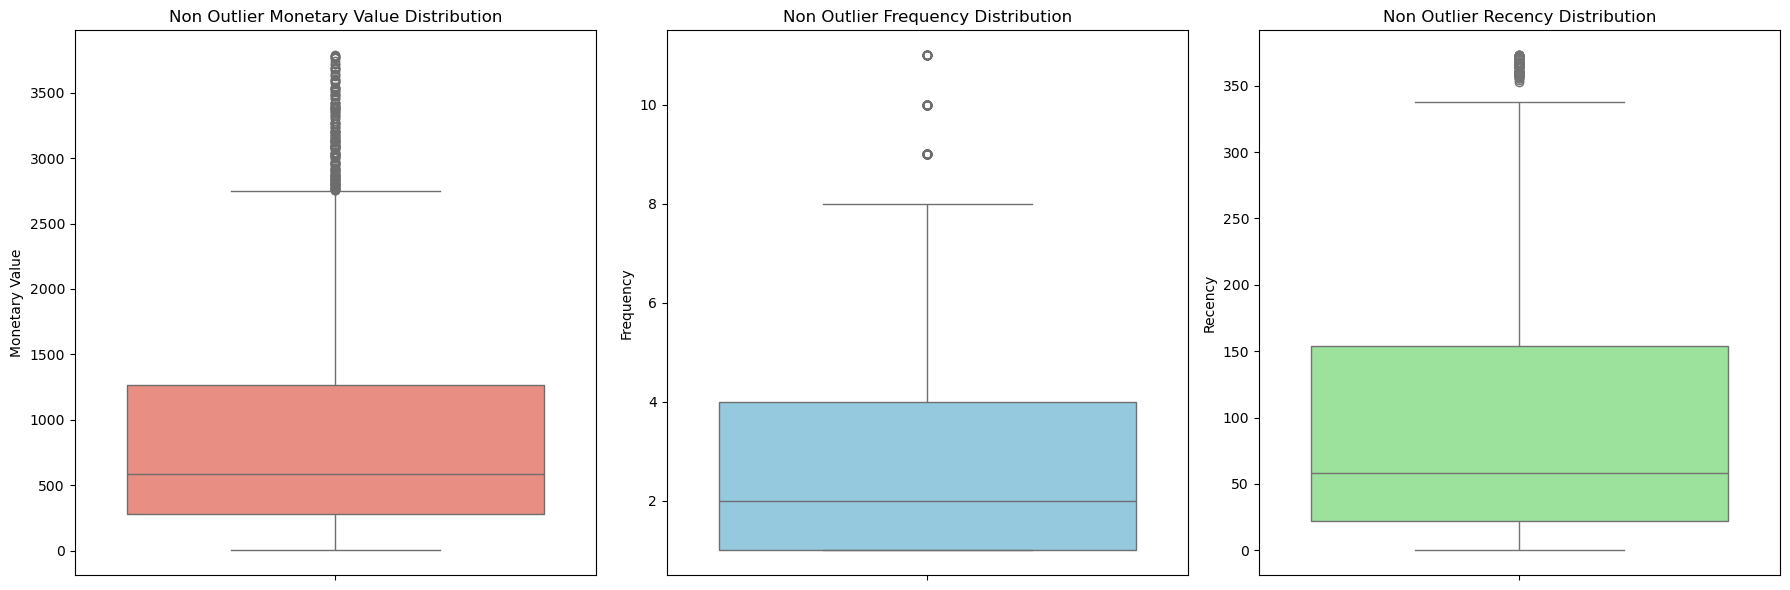

In [10]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
sns.boxplot(y=non_outlier_df['MonetaryValue'],color='salmon')
plt.title('Non Outlier Monetary Value Distribution')
plt.ylabel('Monetary Value')

plt.subplot(1,3,2)
sns.boxplot(y=non_outlier_df['Frequency'] , color='skyblue')
plt.title('Non Outlier Frequency Distribution')
plt.ylabel('Frequency')

plt.subplot(1,3,3)
sns.boxplot(y=non_outlier_df['Recency'] , color='lightgreen')
plt.title('Non Outlier Recency Distribution')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

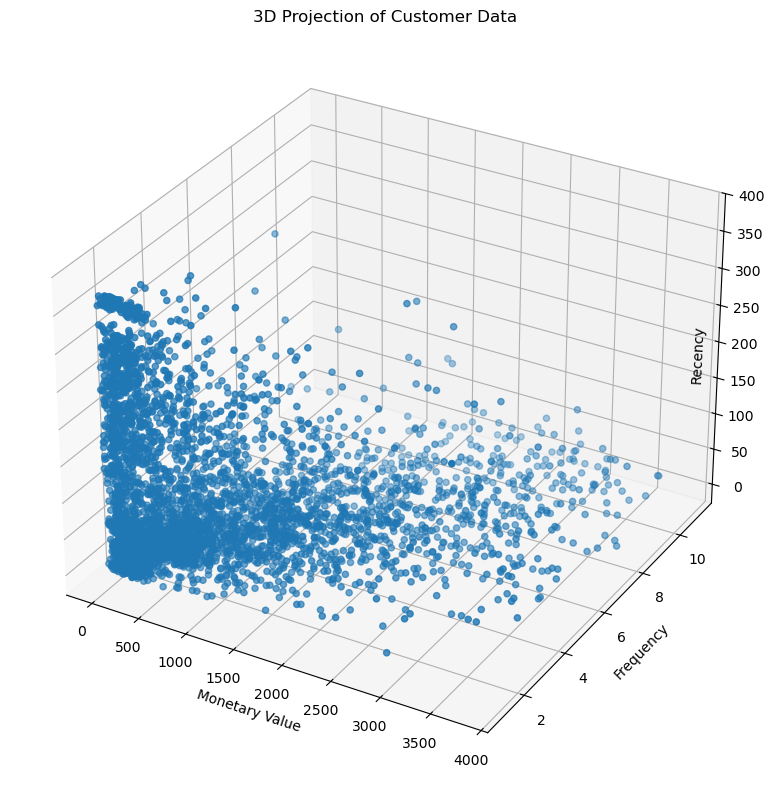

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection = '3d')

scatter = ax.scatter(non_outlier_df['MonetaryValue'], non_outlier_df['Frequency'] , non_outlier_df['Recency'])
plt.title('3D Projection of Customer Data')
ax.set_ylabel('Frequency')
ax.set_xlabel('Monetary Value')
ax.set_zlabel('Recency')
ax.zaxis.labelpad= -30

plt.tight_layout()
plt.show()


In [12]:
scaler = StandardScaler()
scaled_l = scaler.fit_transform(non_outlier_df[['MonetaryValue','Frequency','Recency']])
scaled_df = pd.DataFrame(scaled_l , index = non_outlier_df.index , 
                         columns = ['MonetaryValue','Frequency','Recency'])

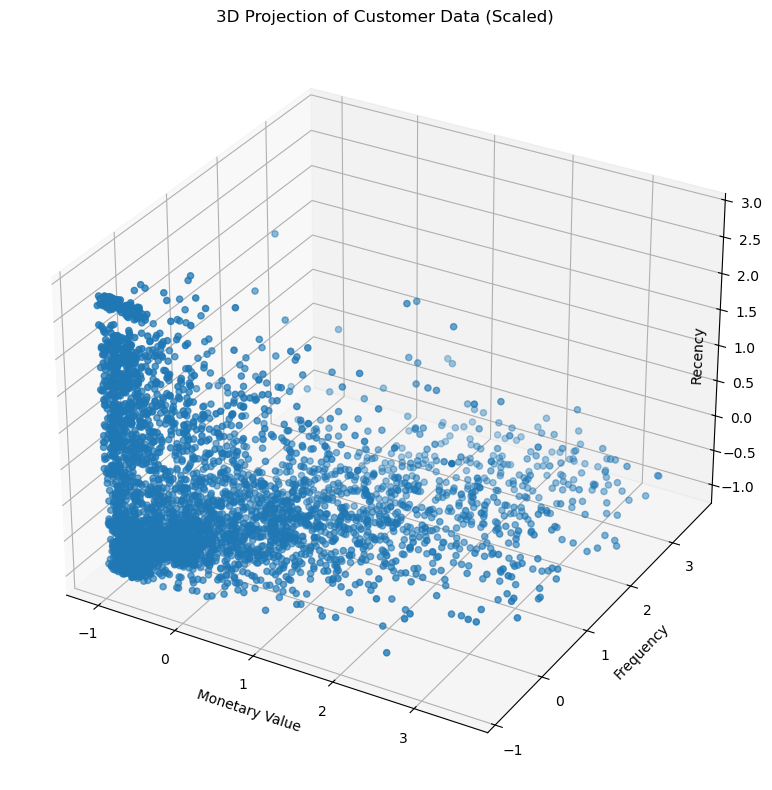

In [13]:
fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(projection = '3d')

scatter = ax.scatter(scaled_df['MonetaryValue'],scaled_df['Frequency'],scaled_df['Recency'])
plt.title('3D Projection of Customer Data (Scaled)')
ax.set_ylabel('Frequency')
ax.set_xlabel('Monetary Value')
ax.set_zlabel('Recency')
ax.zaxis.labelpad= -30

plt.tight_layout()
plt.show()

In [14]:
max_k = 12 
k_val = range(2,max_k+1)
sil_score = []
inertia = []

for k in k_val : 
    kmean = KMeans(n_clusters=k , max_iter=1000 , random_state= 42 )
    cluster_labels = kmean.fit_predict(scaled_df)
    silho = silhouette_score(scaled_df,cluster_labels)
    sil_score.append(silho)
    inertia.append(kmean.inertia_)

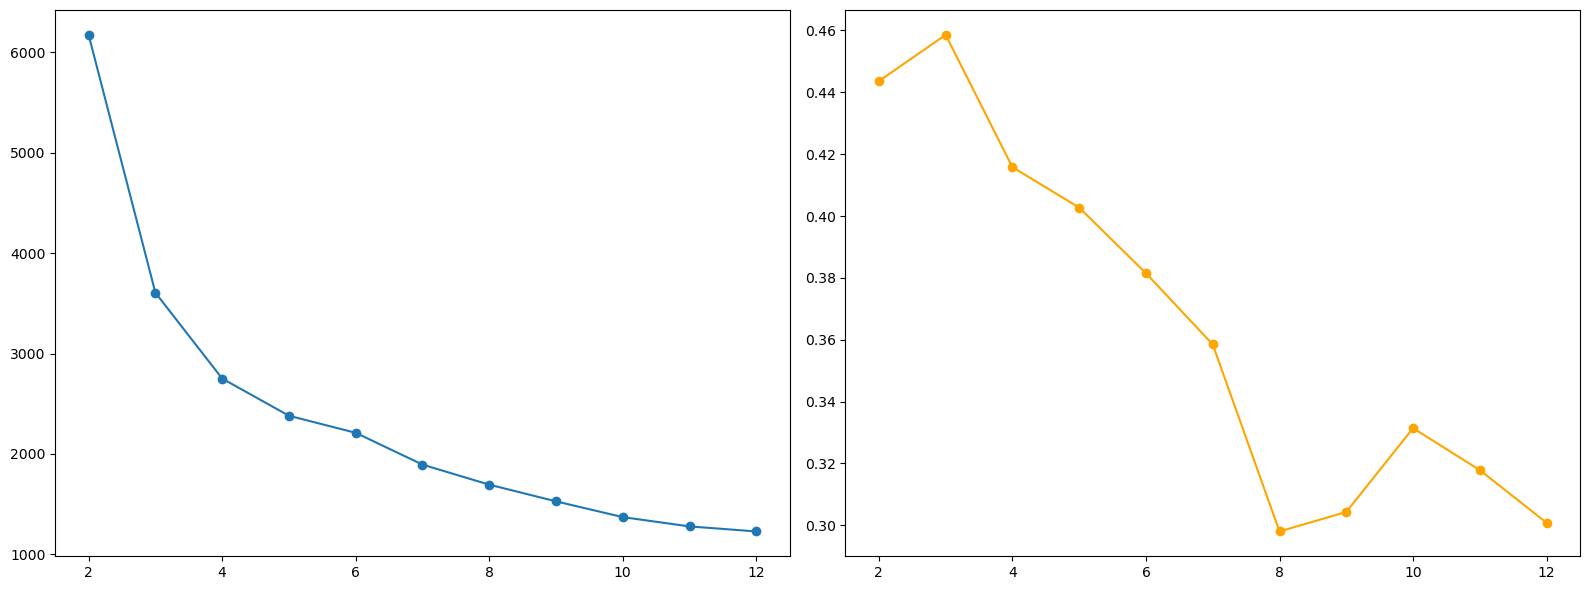

In [15]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(k_val,inertia,marker='o')

plt.subplot(1,2,2)
plt.plot(k_val,sil_score,color ='orange', marker = 'o')

plt.tight_layout()
plt.show()

In [16]:
# Running algorithm with 4 clusters and mapping colors to them
kmean = KMeans(n_clusters=4, max_iter=1000, random_state=42)

cluster_label = kmean.fit_predict(scaled_df)
non_outlier_df['Clusters'] = cluster_label

cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                  3: '#d62728'}  # Red

col = non_outlier_df['Clusters'].map(cluster_colors)


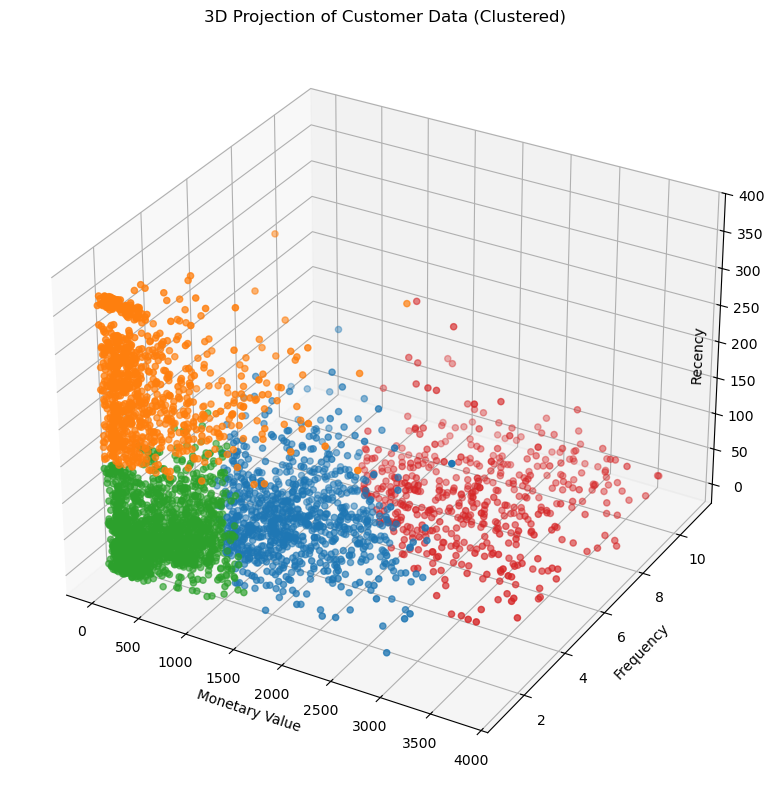

In [17]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection ='3d')
sc = ax.scatter(non_outlier_df['MonetaryValue'],non_outlier_df['Frequency'],non_outlier_df['Recency'], c=col , marker='o')

plt.title('3D Projection of Customer Data (Clustered)')
ax.set_ylabel('Frequency')
ax.set_xlabel('Monetary Value')
ax.set_zlabel('Recency')
ax.zaxis.labelpad= -30

plt.tight_layout()
plt.show()

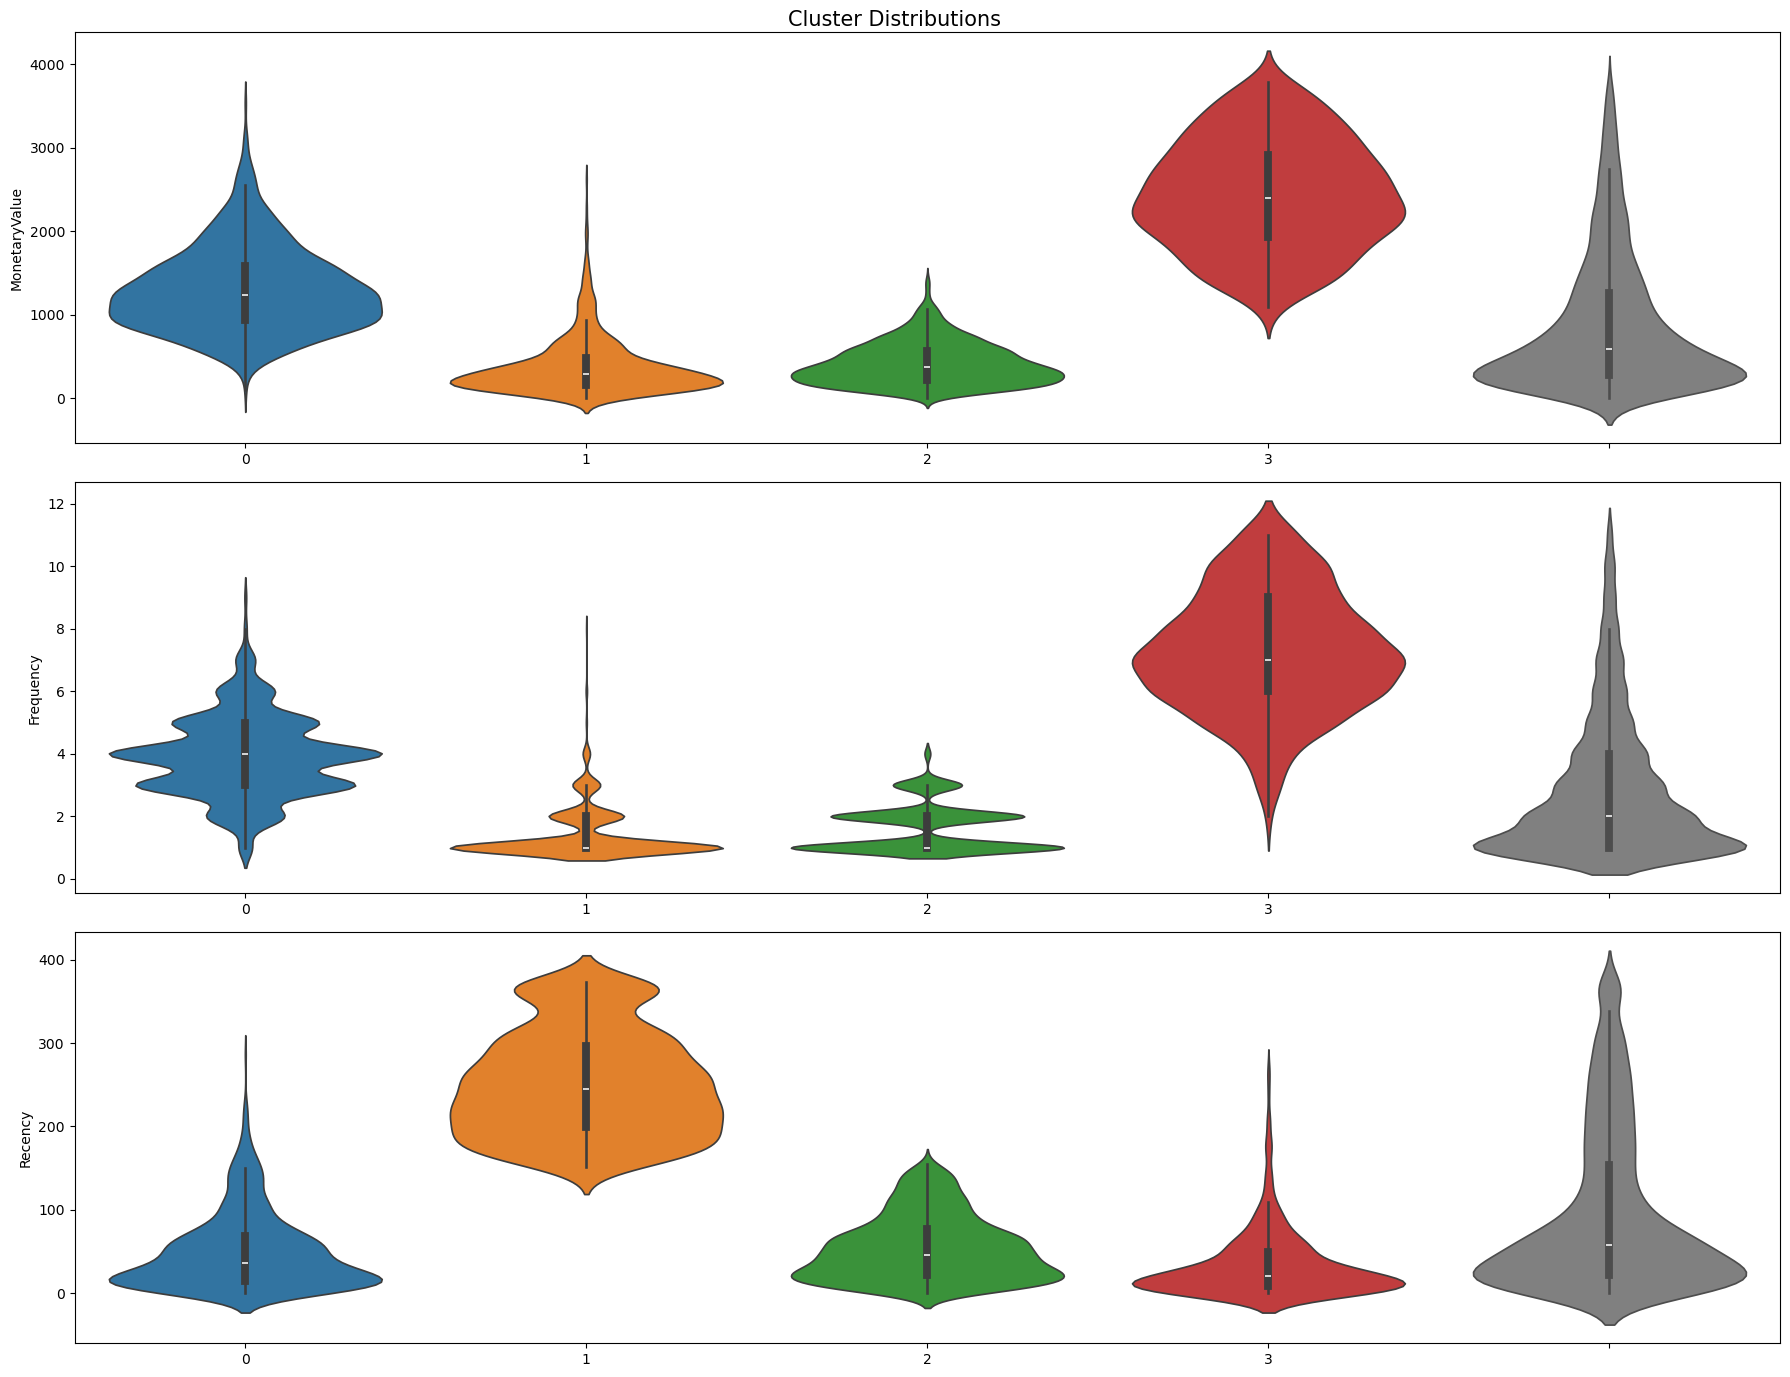

In [18]:
plt.figure(figsize=(18,14))

plt.subplot(3,1,1)
sns.violinplot(x=non_outlier_df['Clusters'],y = non_outlier_df['MonetaryValue'],hue=non_outlier_df['Clusters'],palette=cluster_colors,legend=False)
sns.violinplot(y=non_outlier_df['MonetaryValue'],color='gray')
plt.xlabel('')

plt.subplot(3,1,2)
sns.violinplot(x=non_outlier_df['Clusters'],y = non_outlier_df['Frequency'],hue=non_outlier_df['Clusters'],palette=cluster_colors,legend=False)
sns.violinplot(y=non_outlier_df['Frequency'],color='gray')
plt.xlabel('')

plt.subplot(3,1,3)
sns.violinplot(x=non_outlier_df['Clusters'],y = non_outlier_df['Recency'],hue=non_outlier_df['Clusters'],palette=cluster_colors,legend=False)
sns.violinplot(y=non_outlier_df['Recency'],color='gray')
plt.xlabel('')

plt.suptitle('Cluster Distributions',fontsize= 15)
plt.tight_layout()
plt.show()

In [ ]:

mon_freq = freq_outliers.index.intersection(mon_outliers.index)
mon_only_outlier = mon_outliers.loc[~mon_outliers.index.isin(mon_freq)]
freq_only_outlier = freq_outliers.loc[~freq_outliers.index.isin(mon_freq)]
mon_freq_outlier = mon_outliers.loc[mon_freq]

mon_only_outlier['Clusters'] = -1 
freq_only_outlier['Clusters'] = -2 
mon_freq_outlier['Clusters'] = -3 

full_outlier = pd.concat([mon_only_outlier,freq_only_outlier,mon_freq_outlier])



In [20]:
outlier_colors = {
                  -1: '#800080',  
                  -2: '#FA8072',  
                  -3: '#00FFFF'}  


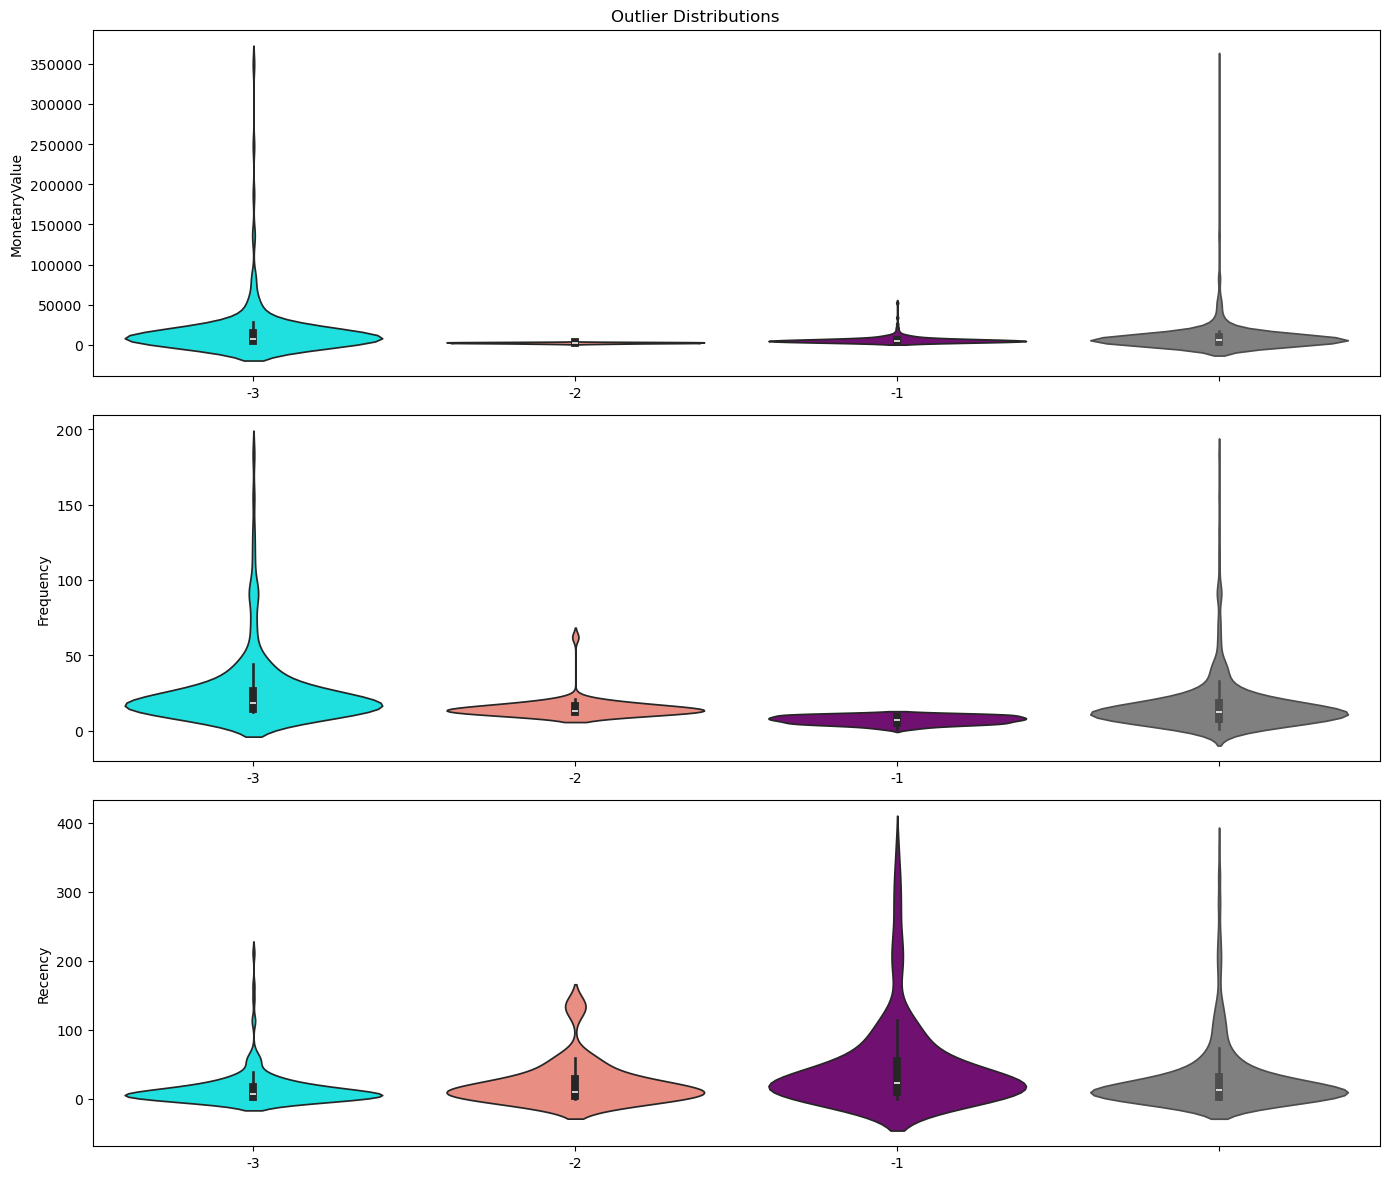

In [ ]:
plt.figure(figsize=(14,12))

plt.subplot(3,1,1)
sns.violinplot(x=full_outlier['Clusters'],y=full_outlier['MonetaryValue'], hue=full_outlier['Clusters'], palette=outlier_colors,legend=False)
sns.violinplot(y=full_outlier['MonetaryValue'],color='gray')
plt.xlabel('')

plt.subplot(3,1,2)
sns.violinplot(x=full_outlier['Clusters'],y=full_outlier['Frequency'], hue=full_outlier['Clusters'], palette=outlier_colors,legend=False)
sns.violinplot(y=full_outlier['Frequency'],color='gray')
plt.xlabel('')

plt.subplot(3,1,3)
sns.violinplot(x=full_outlier['Clusters'],y=full_outlier['Recency'], hue=full_outlier['Clusters'], palette=outlier_colors,legend=False)
sns.violinplot(y=full_outlier['Recency'],color='gray')
plt.xlabel('')

plt.suptitle('Outlier Distributions')
plt.tight_layout()
plt.show()

In [31]:
#Joining data
full_df = pd.concat([non_outlier_df,full_outlier])

cluster_names = {
    -3: "Whales",         # High spending and frequency, inconsistent recency
    -2: "Dormants",       # Extremely low spending and activity
    -1: "Lurkers",        # Low to moderate spending and engagement
    0: "Regulars",        # Moderate spending, consistent activity
    1: "Sleepers",        # Low spending, infrequent activity
    2: "Occasionals",     # Predictable low spending and rare activity
    3: "Elites"           # High spending, frequent, and recent activity
}

In [32]:
full_df['ClusterLabels'] = full_df['Clusters'].map(cluster_names)

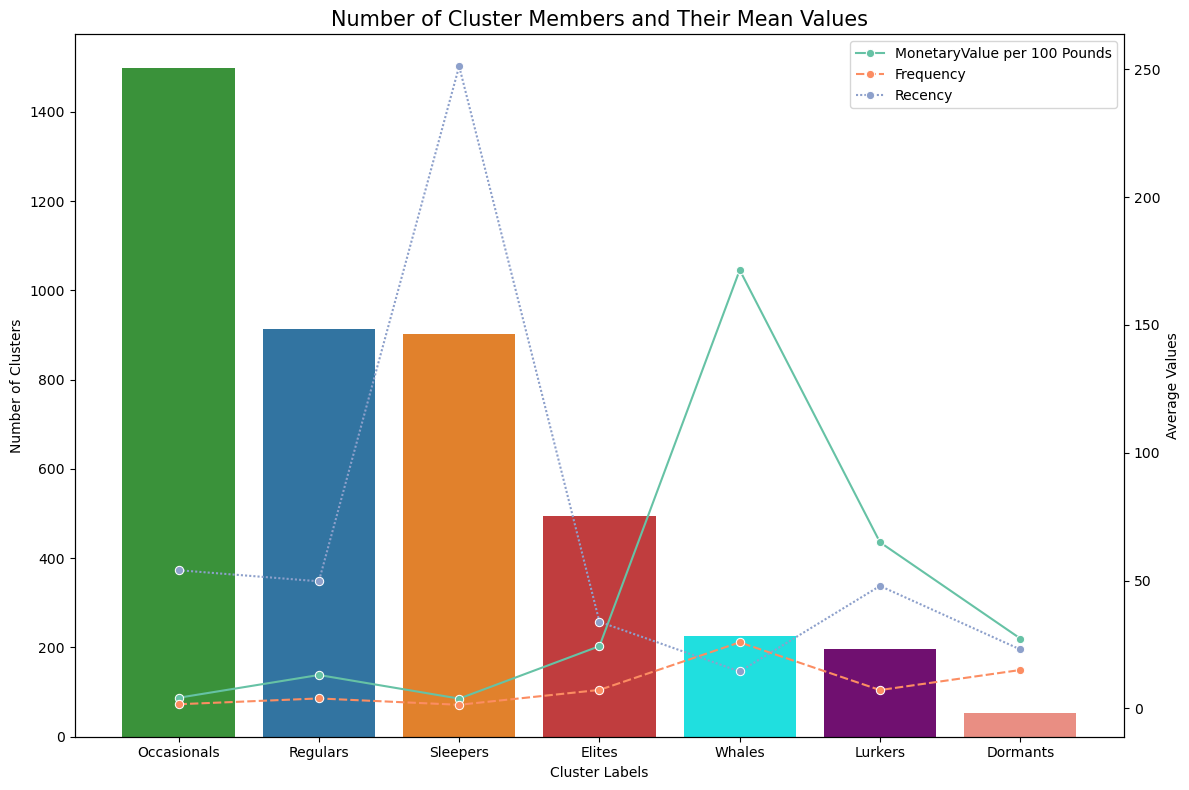

In [33]:
full_colors = {   'Regulars': '#1f77b4',  
                  'Sleepers': '#ff7f0e',  
                  'Occasionals': '#2ca02c',  
                  'Elites': '#d62728',                    
                  'Lurkers': '#800080',  
                 "Dormants": '#FA8072',  
                 "Whales": '#00FFFF' }


cluster_count = full_df['ClusterLabels'].value_counts().reset_index(name='count')
full_colo=cluster_count['ClusterLabels'].map(full_colors)


full_df['MonetaryValue per 100 Pounds'] = full_df['MonetaryValue']/ 100 
cluster_means = full_df.groupby('ClusterLabels')[['MonetaryValue per 100 Pounds','Frequency','Recency']].mean()

fig  , ax1 = plt.subplots(figsize=(12,8))
sns.barplot(x=cluster_count['ClusterLabels'],y=cluster_count['count'] , hue=cluster_count['ClusterLabels'] ,palette =full_colors,ax=ax1)
plt.xlabel('Cluster Labels')
ax1.set_ylabel('Number of Clusters')
ax2= ax1.twinx()

sns.lineplot(cluster_means,markers=['o']*3 ,palette='Set2',ax=ax2)
ax2.set_ylabel('Average Values')

plt.title('Number of Cluster Members and Their Mean Values' , fontsize = 15)

plt.tight_layout()
plt.show()